In [10]:
from pathlib import Path
import sys, os
import numpy as np
import pandas as pd
import json, jsonlines
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import nltk
import seaborn as sns

while Path.cwd().name != 'dexperts':
    %cd ..

from scripts.data.openwebtext import OWTC

## get 100k subset of OWT prompts using reservoir sampling

In [ ]:
def reservoir_sampling(l, k):
    it = iter(l)
    try:
        result = [next(it) for _ in range(k)] # use xrange if on python 2.x
    except StopIteration:
        raise ValueError("Sample larger than population")

    for i, item in tqdm_notebook(enumerate(it, start=k)):
        s = random.randint(0, i)
        if s < k:
            result[s] = item

    random.shuffle(result)
    return result

In [ ]:
with open('prompts/sentiment_prompts.jsonl', 'r') as fin, open('prompts/sentiment_prompts-100k.jsonl', 'w') as fo:
    for line in reservoir_sampling(fin, 100000):
        fo.write(line)

## sentiment distribution of GPT-2 generations on 100k sentiment prompts

In [3]:
generations_df = pd.read_json('generations/sentiment/all_prompts/gpt2/prompted_gens_gpt2.jsonl', lines=True)

In [5]:
num_pos = []

for i, row in tqdm_notebook(generations_df.iterrows(), total=len(generations_df.index)):
    gens_df = pd.DataFrame(row.generations)
    num_pos.append(np.sum(gens_df.label == 'POSITIVE'))

generations_df['num_positive'] = num_pos

<Figure size 432x288 with 0 Axes>

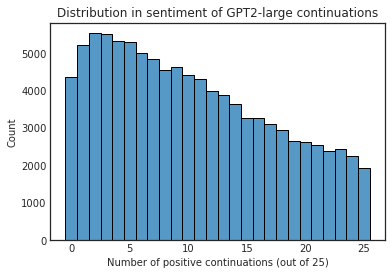

In [11]:
plt.figure()
fig, ax = plt.subplots()
plt.style.use('seaborn-white')
sns.histplot(num_pos, bins=26, discrete=True)
ax.set_xlabel('Number of positive continuations (out of 25)')
plt.title('Distribution in sentiment of GPT2-large continuations')
plt.savefig('figures/sentiment_distribution_gpt2.png')

In [ ]:
generations_df.to_json('prompts/sentiment_prompts-100k.jsonl', orient='records', lines=True)

## get 10k subset of neutral, positive, and negative prompts

In [2]:
dataset = pd.read_json('prompts/sentiment_prompts-100k.jsonl', lines=True)

In [84]:
# get 2.5k positive generations
prompts_size = 2500
positive_idxs = []
num_pos = 25

while len(positive_idxs) < prompts_size:
    need = prompts_size - len(positive_idxs)
    idxs = list(dataset.loc[dataset['num_positive'] == num_pos].index)
    idxs = np.random.choice(idxs, size=np.min([need, len(idxs)]), replace=False)
    positive_idxs.extend(idxs)
    num_pos -= 1

positive_prompts = dataset.loc[positive_idxs]
positive_prompts.to_json('prompts/sentiment_prompts-10k/positive_prompts.jsonl', orient='records', lines=True)

In [7]:
# get 2.5k negative generations
prompts_size = 2500
negative_idxs = []
num_pos = 0

while len(negative_idxs) < prompts_size:
    need = prompts_size - len(negative_idxs)
    idxs = list(dataset.loc[dataset['num_positive'] == num_pos].index)
    idxs = np.random.choice(idxs, size=np.min([need, len(idxs)]), replace=False)
    negative_idxs.extend(idxs)
    num_pos += 1

negative_prompts = dataset.loc[negative_idxs]
negative_prompts.to_json('prompts/sentiment_prompts-10k/negative_prompts.jsonl', orient='records', lines=True)

In [104]:
# get 5k neutral generations
neutral_prompts = dataset.loc[dataset['num_positive'].isin([12, 13])].sample(5000)
neutral_prompts.to_json('prompts/sentiment_prompts-10k/neutral_prompts.jsonl', orient='records', lines=True)